# Code Setup

In [2]:
library(ggplot2)
library(ggplot2)
library(dplyr)
library(patchwork)
library(stargazer)
library(mgcv)
library(stats)
library(TSA)        # For cumulative periodogram
library(ggplot2)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Please cite as: 


 Hlavac, Marek (2022). stargazer: Well-Formatted Regression and Summary Statistics Tables.

 R package version 5.2.3. https://CRAN.R-project.org/package=stargazer 


Loading required package: nlme


Attaching package: ‘nlme’


The following object is masked from ‘package:dplyr’:

    collapse


This is mgcv 1.9-1. For overview type 'help("mgcv-package")'.


Attaching package: ‘TSA’


The following objects are masked from ‘package:stats’:

    acf, arima


The following object is masked from ‘package:utils’:

    tar




# Data Setup

In [3]:
X <- read.table("provided material/data/cex4WindDataInterpolated.csv", sep=",",
header=TRUE, stringsAsFactors=FALSE)
X$t <- as.POSIXct(X$t, tz="UTC")

In [4]:
na_counts <- colSums(is.na(X))
knitr::kable(as.data.frame(na_counts), col.names = c("Missing Values"))
sum(!complete.cases(X))



|    | Missing Values|
|:---|--------------:|
|t   |              0|
|toy |              0|
|p   |            358|
|Ws1 |           1296|
|Wd1 |           1296|
|T1  |           1296|
|Ws2 |           1298|
|Wd2 |           1298|
|T2  |           1298|
|Ws3 |           1300|
|Wd3 |           1300|
|T3  |           1300|

[1] 1658

In [5]:
X_clean <- X[complete.cases(X), ]
sum(!complete.cases(X_clean))
X <- X_clean

[1] 0

In [6]:
head(X)
summary(X$p)

,t,toy,p,Ws1,Wd1,T1,Ws2,Wd2,T2,Ws3,Wd3,T3
,<dttm>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1999-01-01 03:00:00,0.125,1.267,4.9,135.0,275.8,4.9,135.0,275.8,4.9,135.0,275.8
2,1999-01-01 04:00:00,0.167,1.515,5.0,126.9,275.8,5.0,126.9,275.8,5.0,126.9,275.8
3,1999-01-01 05:00:00,0.208,1.915,5.9,135.7,275.5,5.9,135.7,275.5,5.9,135.7,275.5
4,1999-01-01 06:00:00,0.250,1.613,5.3,146.6,275.0,5.3,146.6,275.0,5.3,146.6,275.0
5,1999-01-01 07:00:00,0.292,1.776,6.1,117.4,274.5,5.9,130.2,274.8,5.9,130.2,274.8
6,1999-01-01 08:00:00,0.333,1.998,7.6,133.4,273.9,7.6,133.4,273.9,7.3,142.8,274.0


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.000   0.283   2.827   4.919   7.855  20.300 

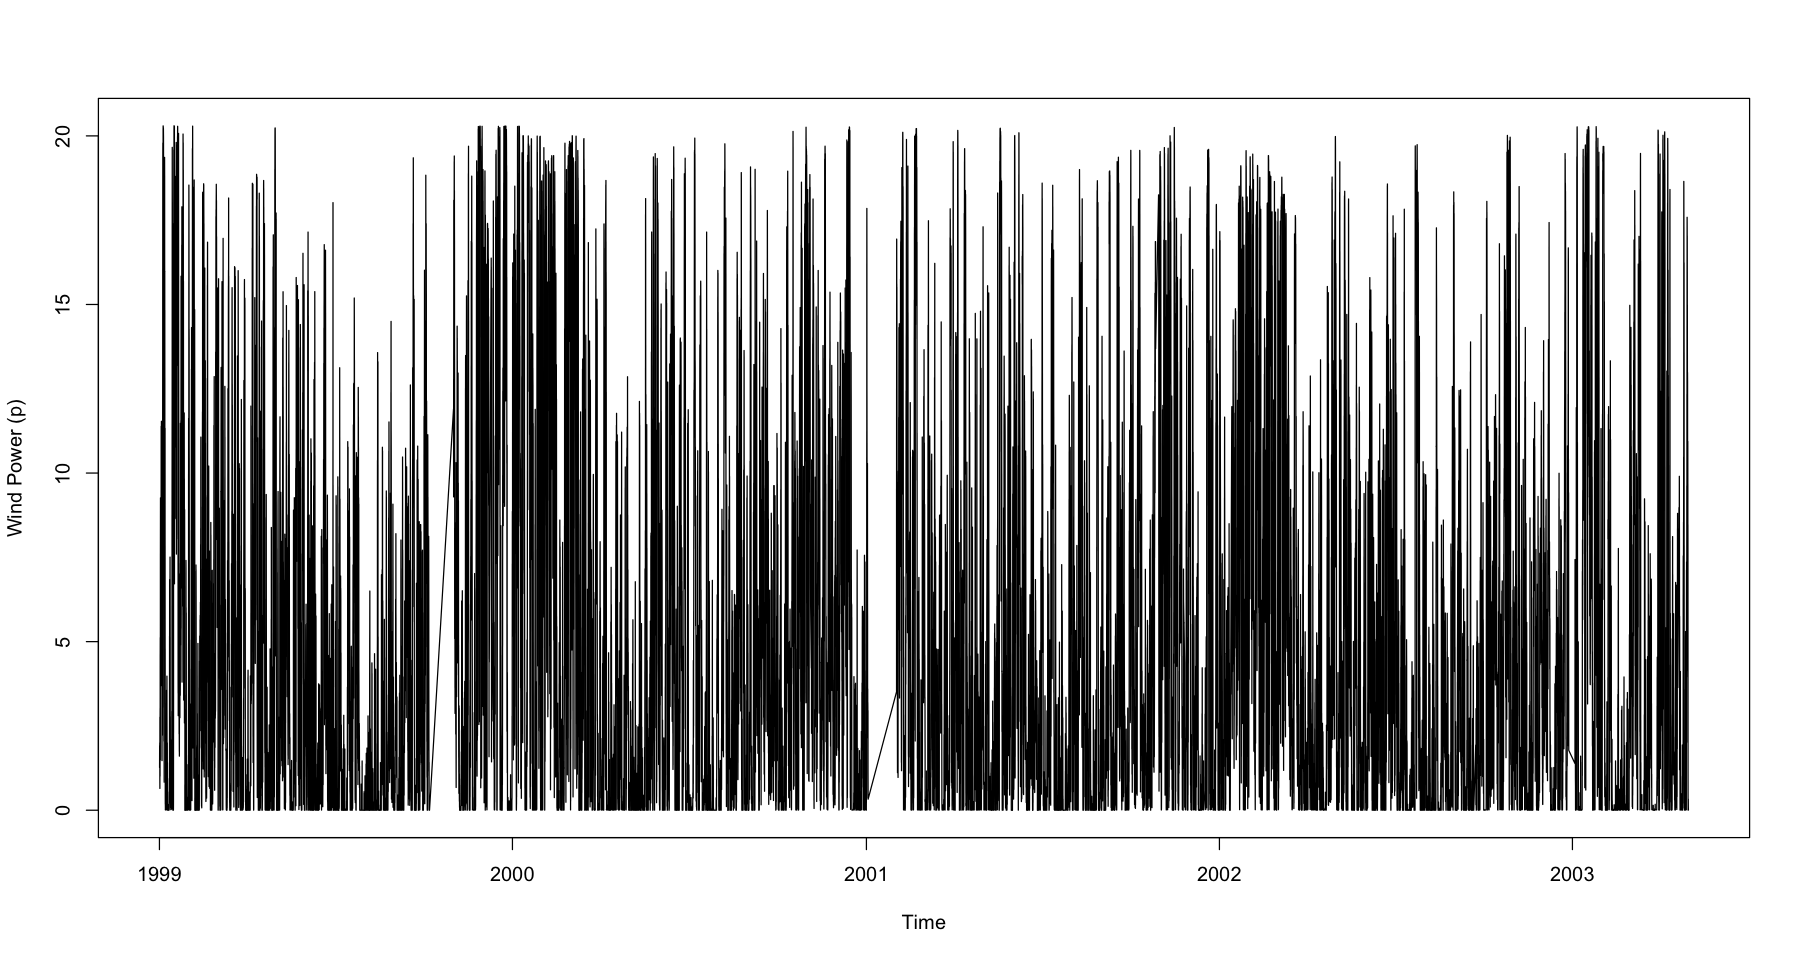

In [7]:
options(repr.plot.width=15, repr.plot.height=8)
plot(X$t, X$p, type="l", xlab="Time", ylab="Wind Power (p)")

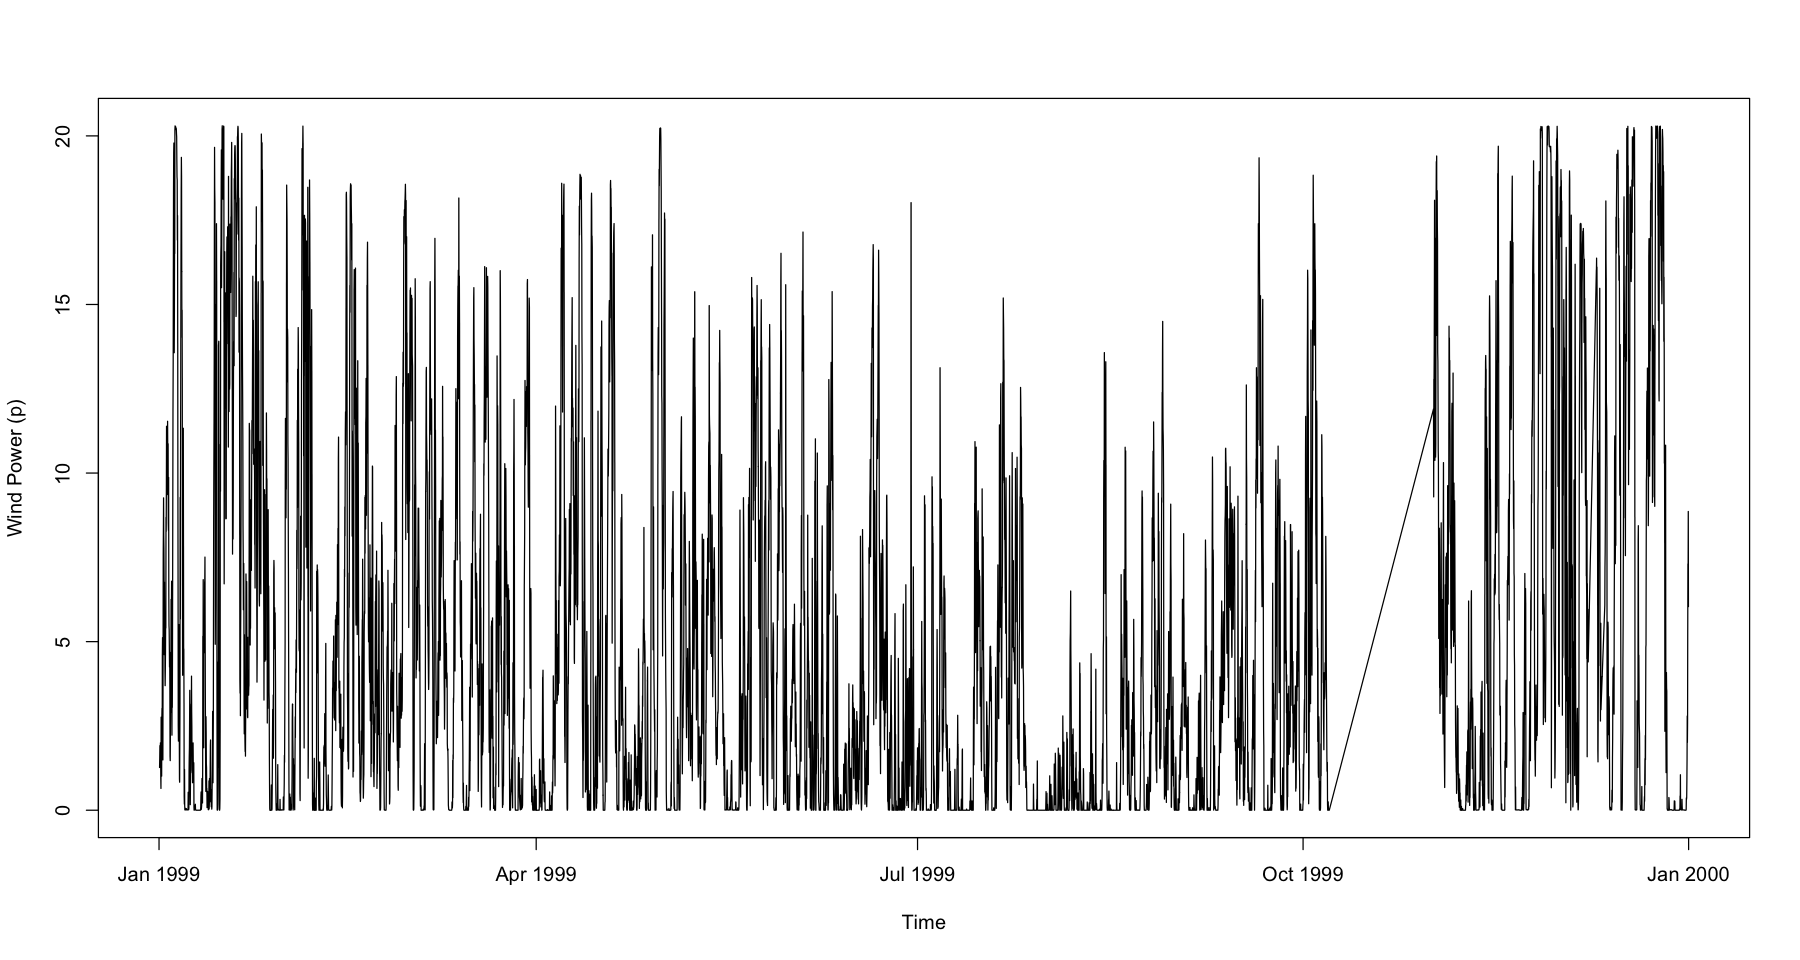

In [8]:
options(repr.plot.width=15, repr.plot.height=8)

# 1 year plot
X1 <- subset(X, t >= as.POSIXct("1999-01-01", tz="UTC") & t < as.POSIXct("2000-01-01", tz="UTC"))
plot(X1$t, X1$p, type="l", xlab="Time", ylab="Wind Power (p)")

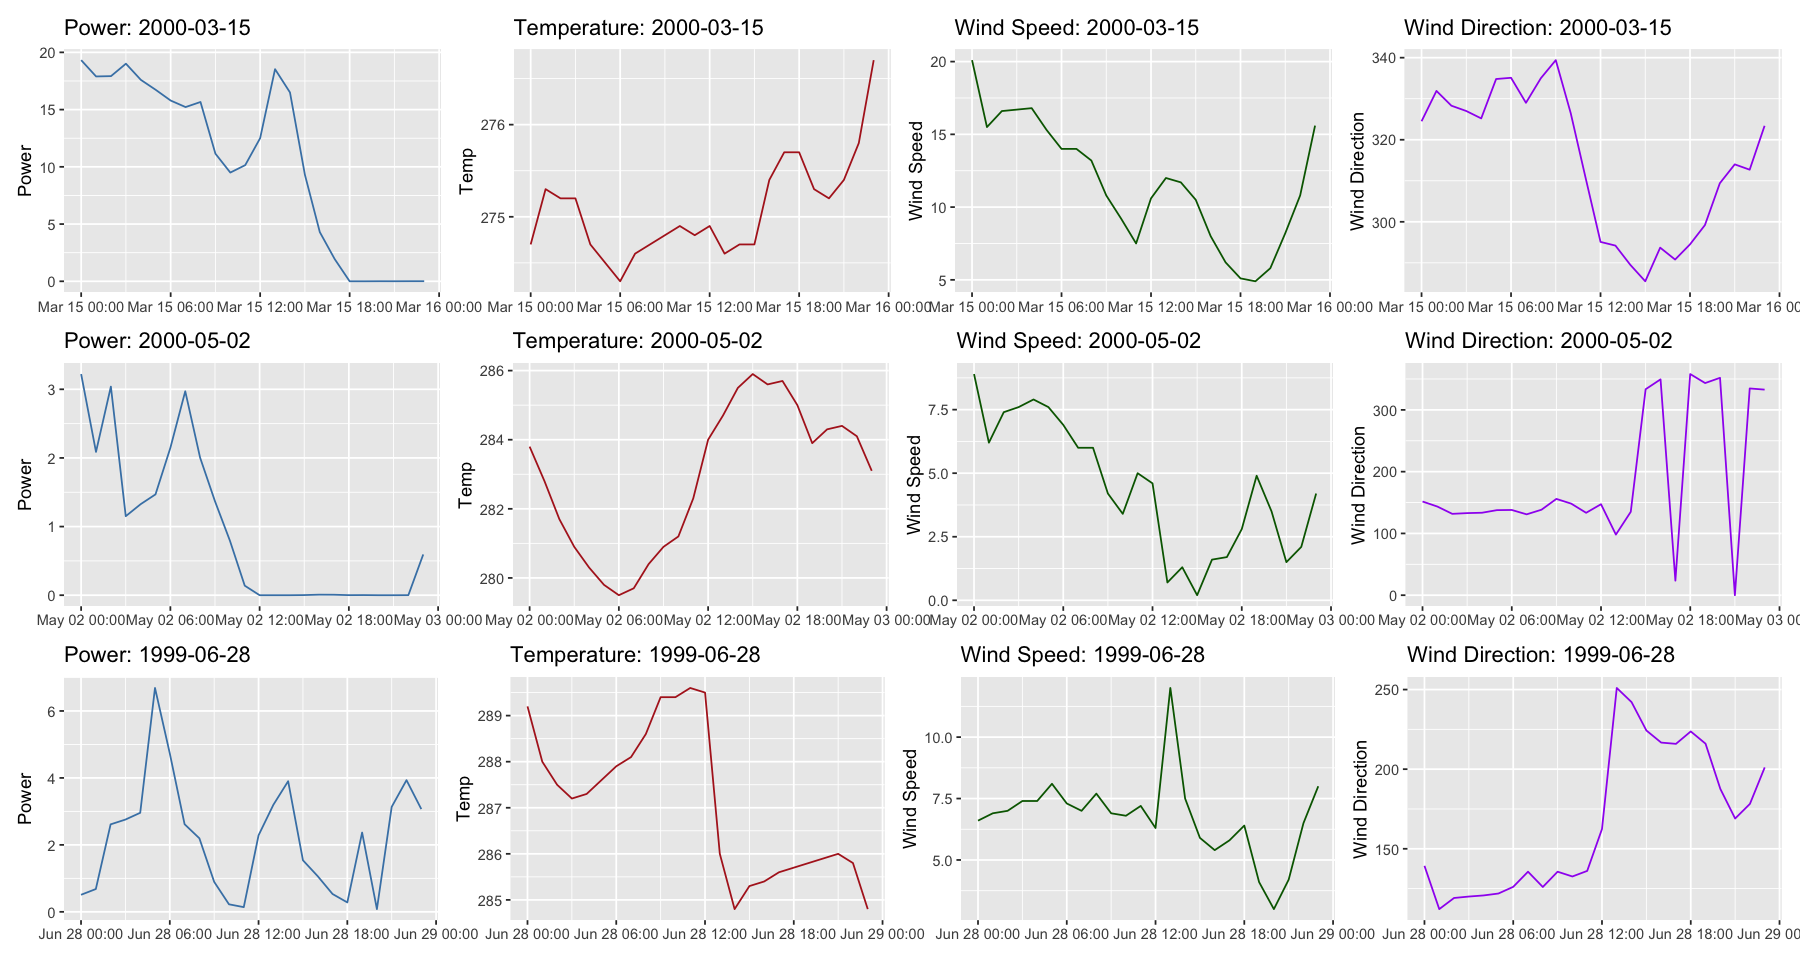

In [9]:
## --- Prepare date field
X$date <- as.Date(X$t)

## --- Select 3 random days
set.seed(123)
days3 <- sample(unique(X$date), 3)

## --- Function that builds a row of 3 plots for a given day
plot_day_row <- function(df_day, day_label) {

  p1 <- ggplot(df_day, aes(x = t, y = p)) +
    geom_line(color = "steelblue") +
    labs(title = paste("Power:", day_label), x = NULL, y = "Power")

  p2 <- ggplot(df_day, aes(x = t, y = T1)) +
    geom_line(color = "firebrick") +
    labs(title = paste("Temperature:", day_label), x = NULL, y = "Temp")

  p3 <- ggplot(df_day, aes(x = t, y = Ws1)) +
    geom_line(color = "darkgreen") +
    labs(title = paste("Wind Speed:", day_label), x = NULL, y = "Wind Speed")
  
  p4 <- ggplot(df_day, aes(x = t, y = Wd1)) +
    geom_line(color = "purple") +
    labs(title = paste("Wind Direction:", day_label), x = NULL, y = "Wind Direction")

  p1 + p2 + p3 + p4 + plot_layout(ncol = 4)
}

## --- Build the full 3-row layout
plots <- lapply(days3, function(d) {
  df_day <- X %>% filter(date == d)
  plot_day_row(df_day, as.character(d))
})

## Combine into rows
final_plot <- wrap_plots(plots, ncol = 1)

final_plot

Across all three days:
	•	When wind speed collapses, power collapses shortly after (Feb 19, Apr 7).
	•	When wind speed stays moderate, power fluctuates but doesn’t vanish (Jun 28).

Temperature moves smoothly, slowly, independently of power or wind speed.

This is expected:
	•	Air density changes with temperature, but the effect is small compared to wind speed.
	•	Nothing in the plots suggests temperature contributes any predictive power on hourly scales.


Model implications

The system has thresholds: when wind drops below ~4 m/s, power always goes to zero. Threshold models, logistic activation of nonlinear terms, or a learned power curve would help.

In [10]:
# Pure autoregressive model
model.ar <- arima(x = X$p, order = c(4,0,0))

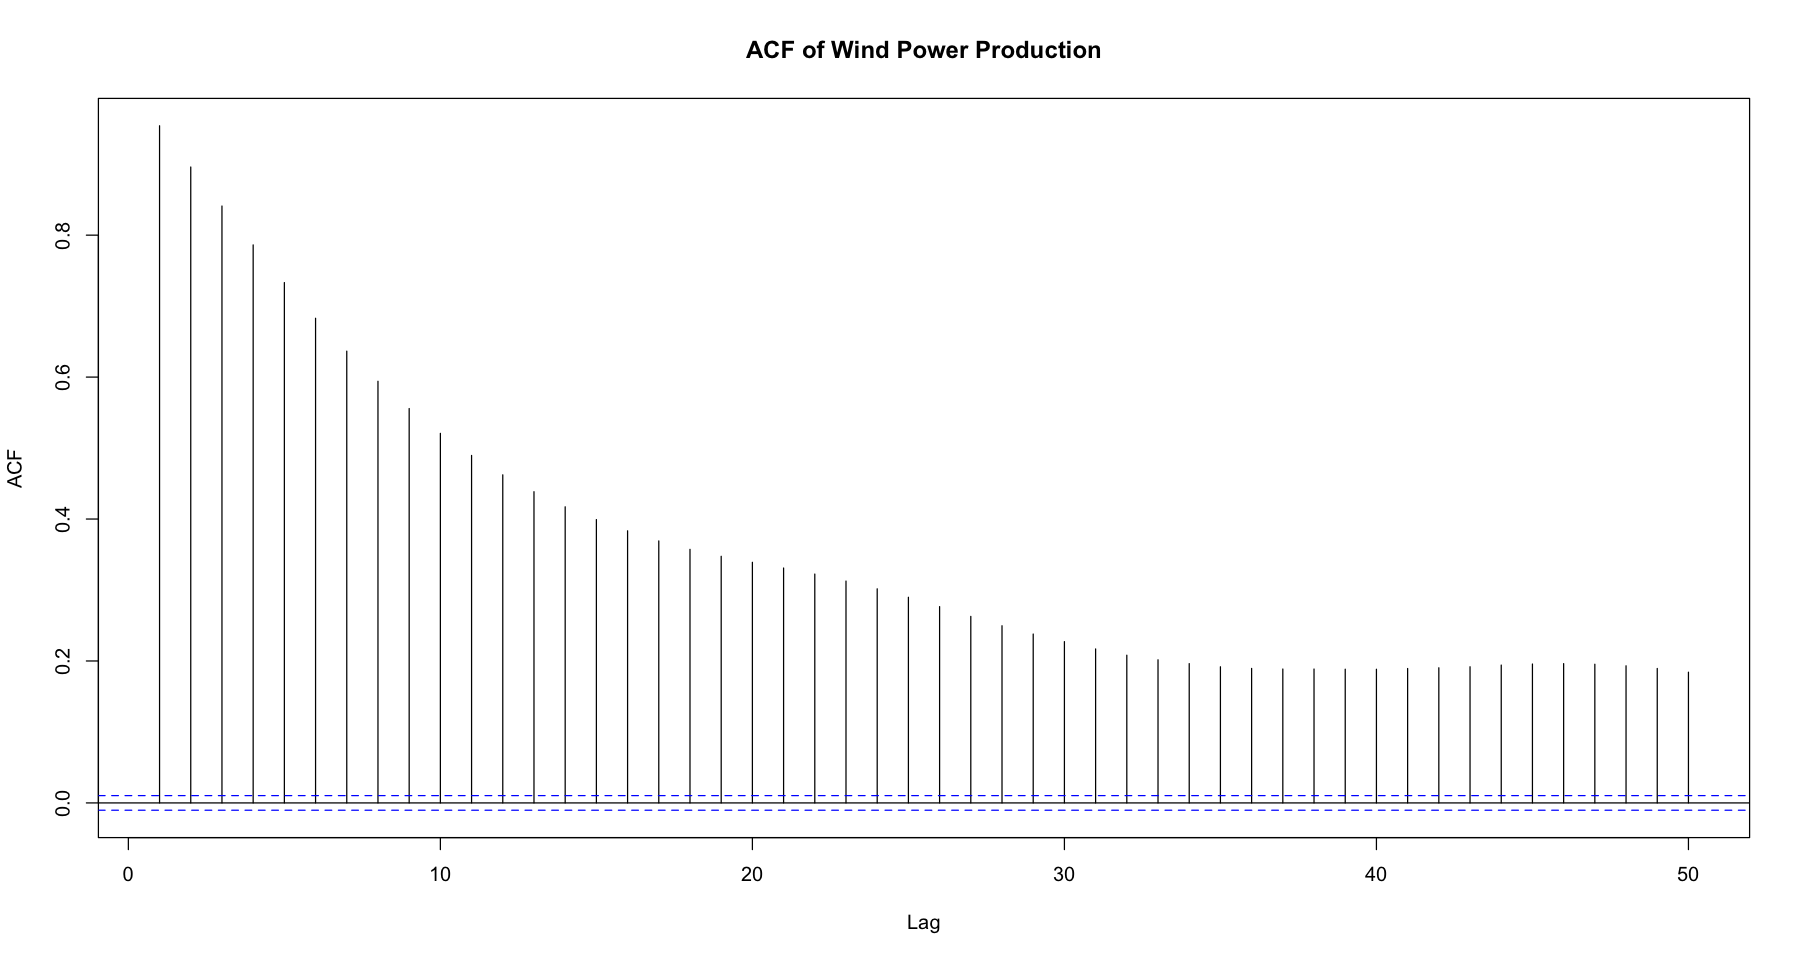

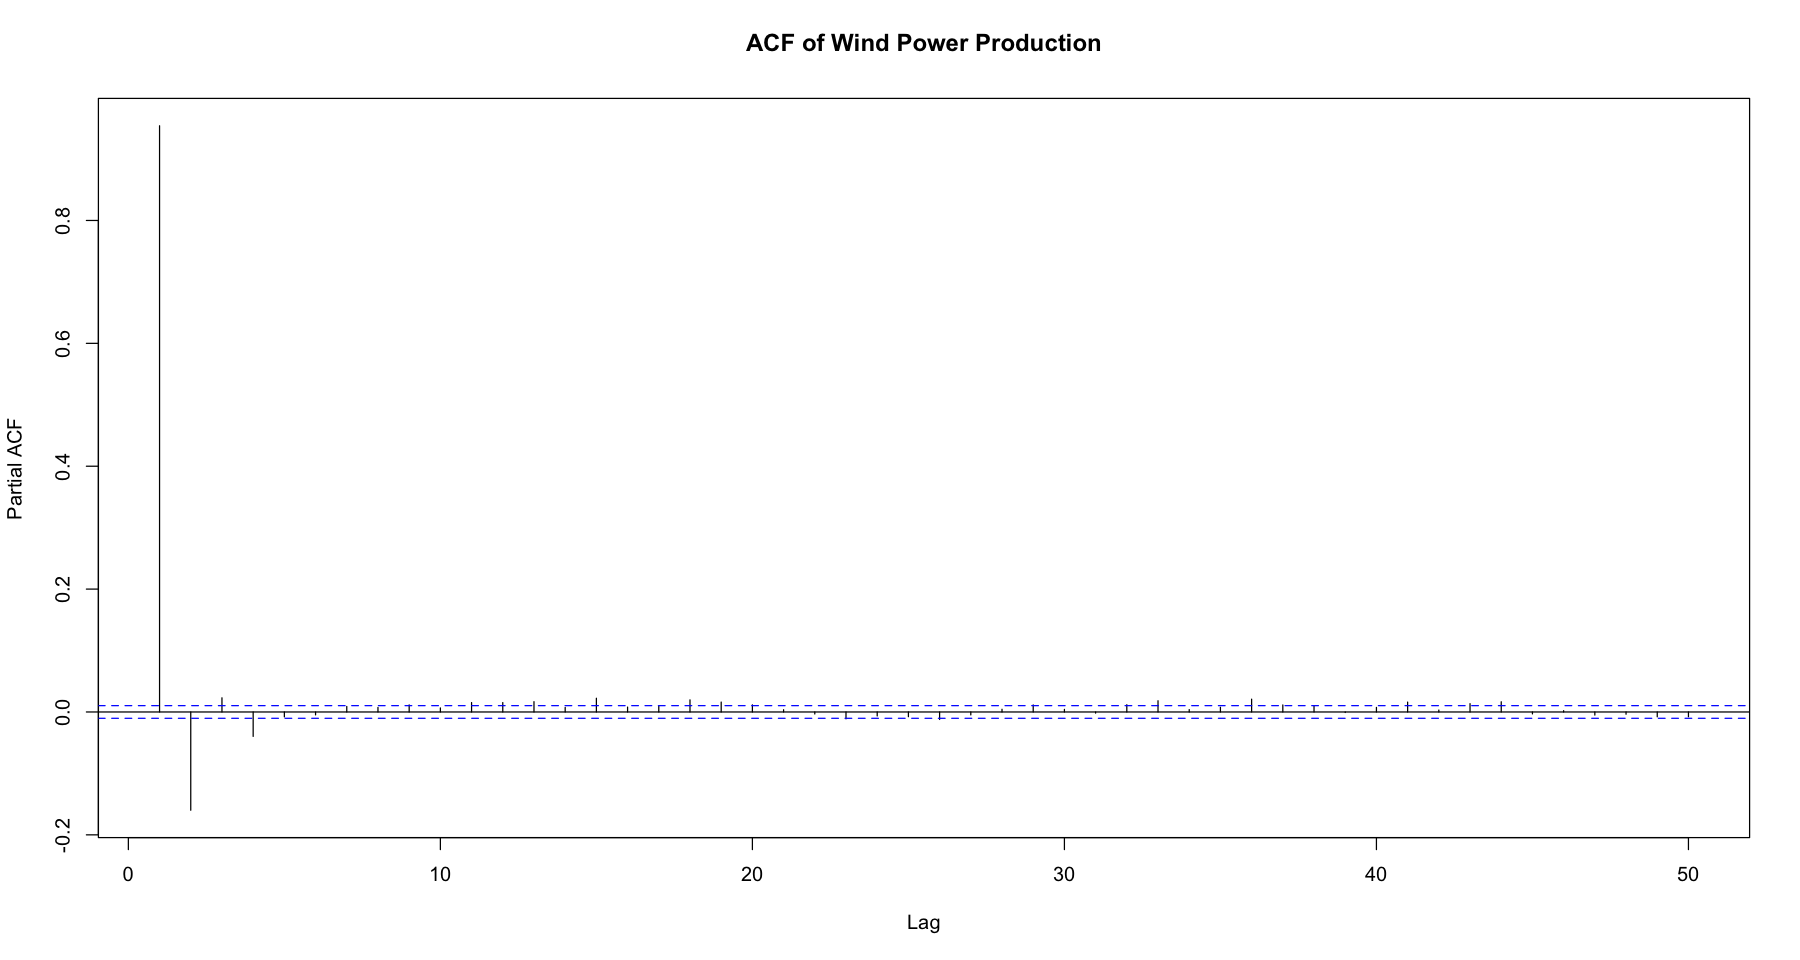

In [11]:
acf(X$p, lag.max = 50, main = "ACF of Wind Power Production")
pacf(X$p, lag.max = 50, main = "ACF of Wind Power Production")

In [12]:
stargazer(model.ar, type = "text")


                      Dependent variable:    
                  ---------------------------
                                             
---------------------------------------------
ar1                        1.111***          
                            (0.005)          
                                             
ar2                        -0.193***         
                            (0.008)          
                                             
ar3                        0.067***          
                            (0.008)          
                                             
ar4                        -0.040***         
                            (0.005)          
                                             
intercept                  4.919***          
                            (0.158)          
                                             
---------------------------------------------
Observations                36,283           
Log Likelihood            -69,046


                      Dependent variable:    
                  ---------------------------
                                             
---------------------------------------------
ar1                        1.114***          
                            (0.007)          
                                             
ar2                        -0.185***         
                            (0.011)          
                                             
ar3                        0.051***          
                            (0.011)          
                                             
ar4                        -0.026**          
                            (0.011)          
                                             
ar5                          0.003           
                            (0.011)          
                                             
ar6                        -0.025**          
                            (0.011)          
                                 

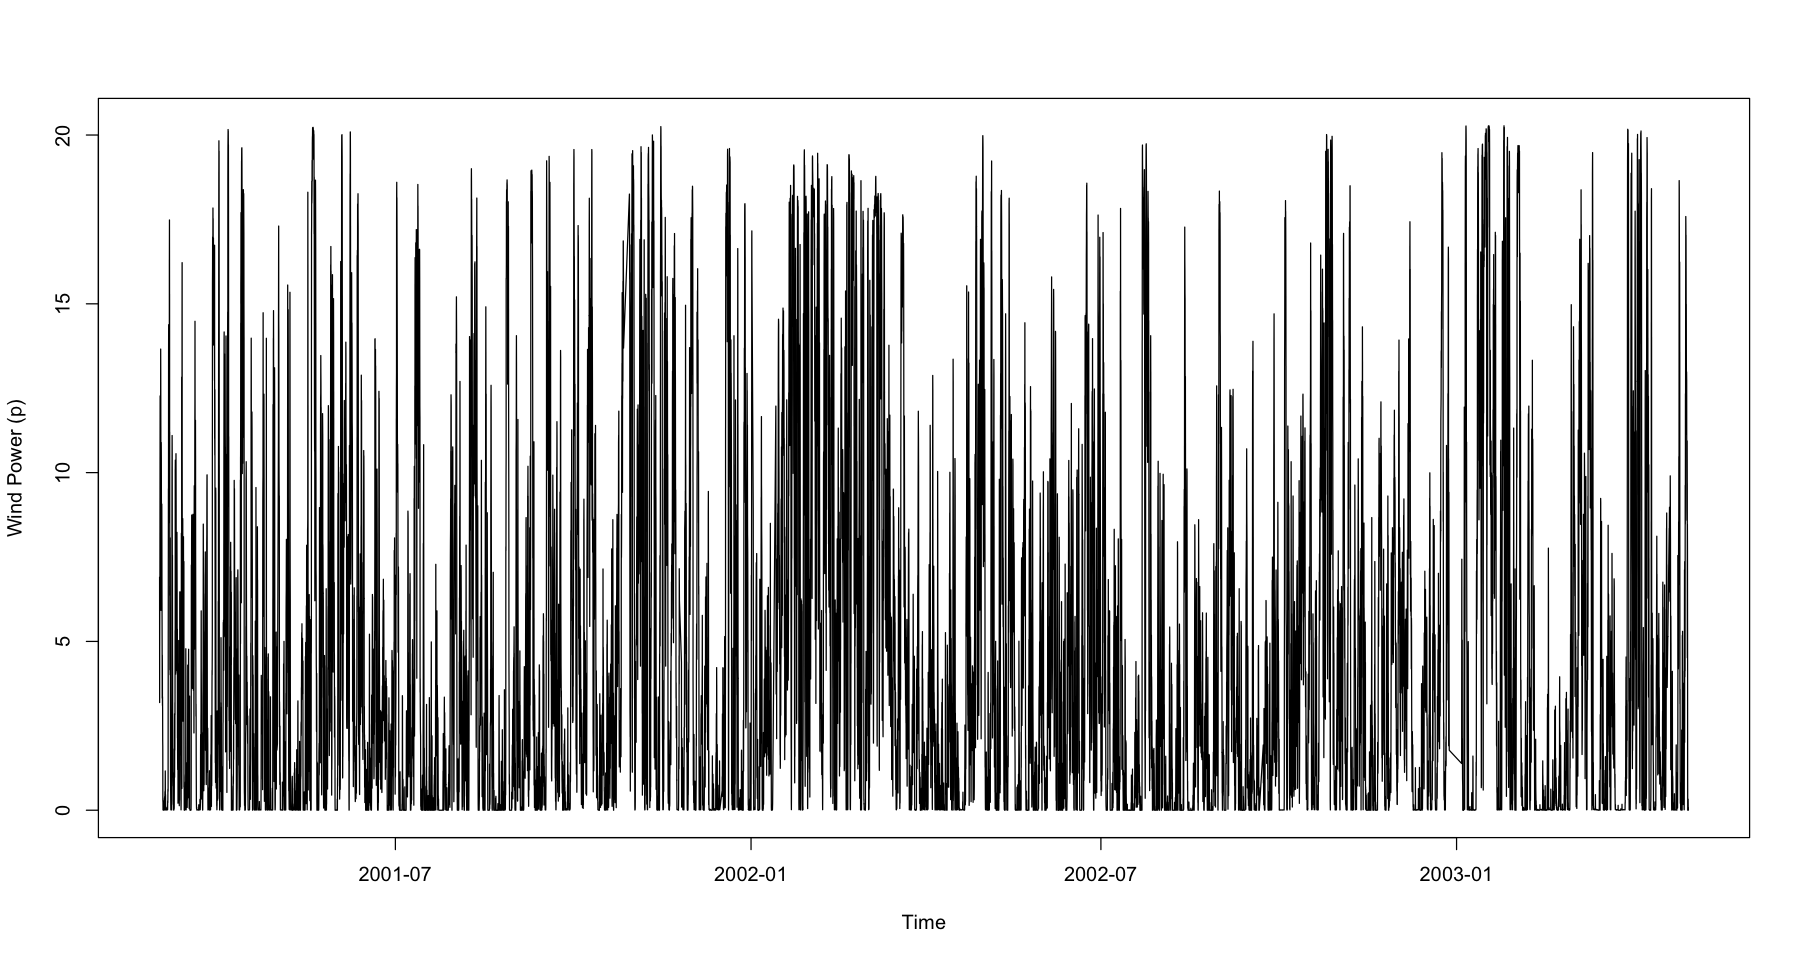

In [13]:
options(repr.plot.width=15, repr.plot.height=8)

# 1 year plot
X2 <- subset(X, t >= as.POSIXct("2001-03-01", tz="UTC"))
plot(X2$t, X2$p, type="l", xlab="Time", ylab="Wind Power (p)")
model.ar_one_year <- arima(x = X2$p, order = c(10,0,0))
stargazer(model.ar_one_year, type = "text")

From the ACF plot and The system clearly retains influence from the previous 4 hours. If the wind drops suddenly, the rotor inertia and atmospheric mixing don’t collapse instantly.

Why AR(6) appears significant

This is typical for wind series:
The ACF is smooth and slow, so Yule-Walker or ML estimation will find lingering significance for lags 5–7 even when they’re small.

It does not mean AR(6) is a “true” structural lag.
It means atmospheric persistence still matters at ~6 hours, but weakly.


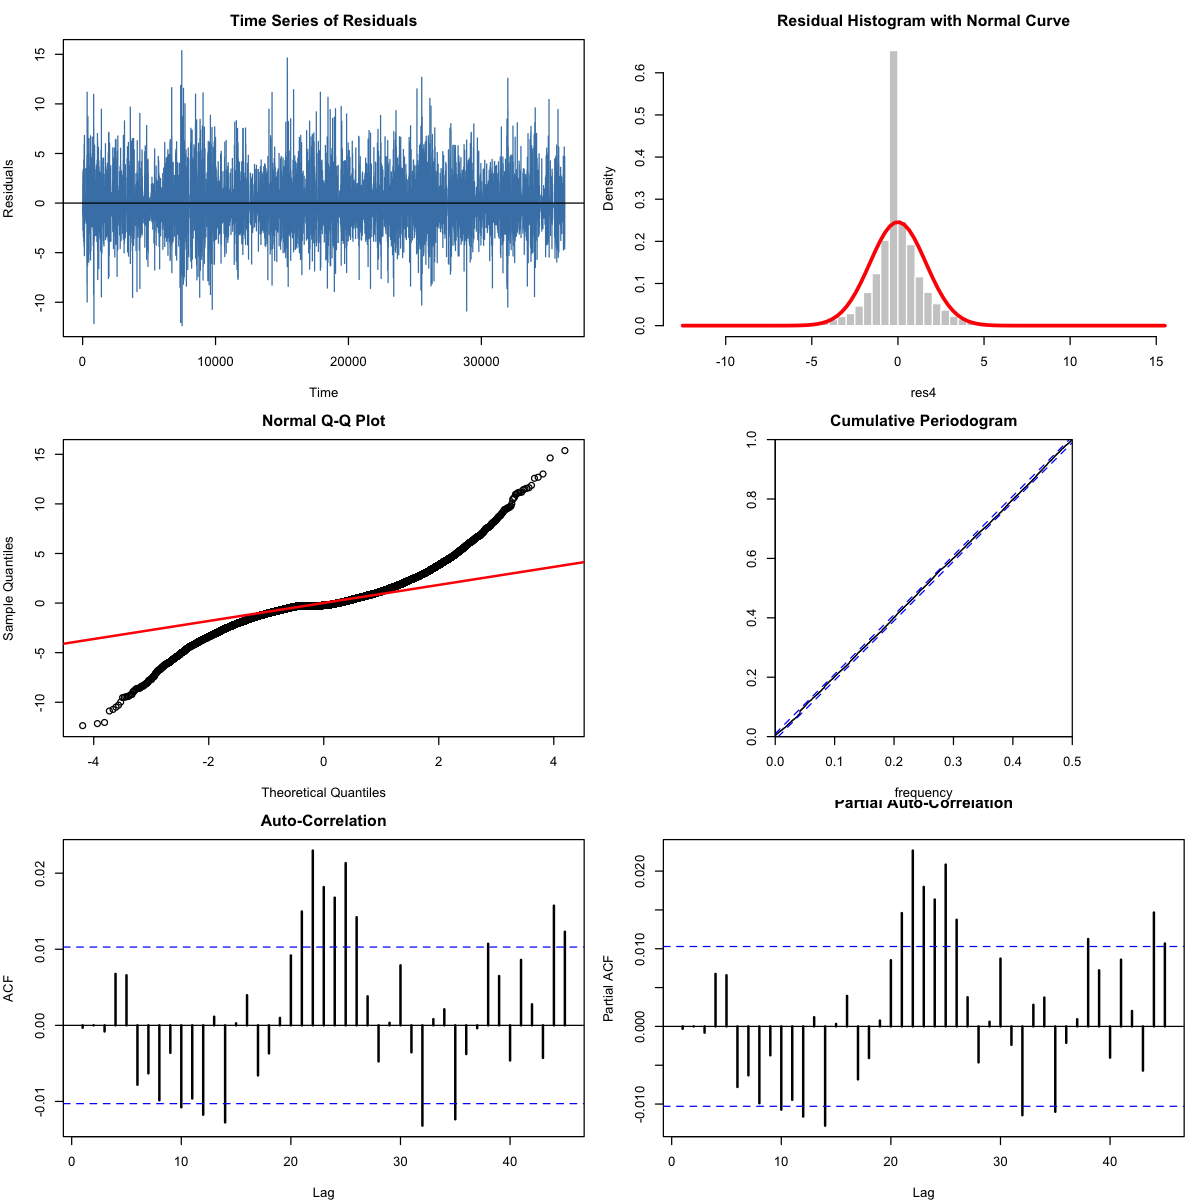

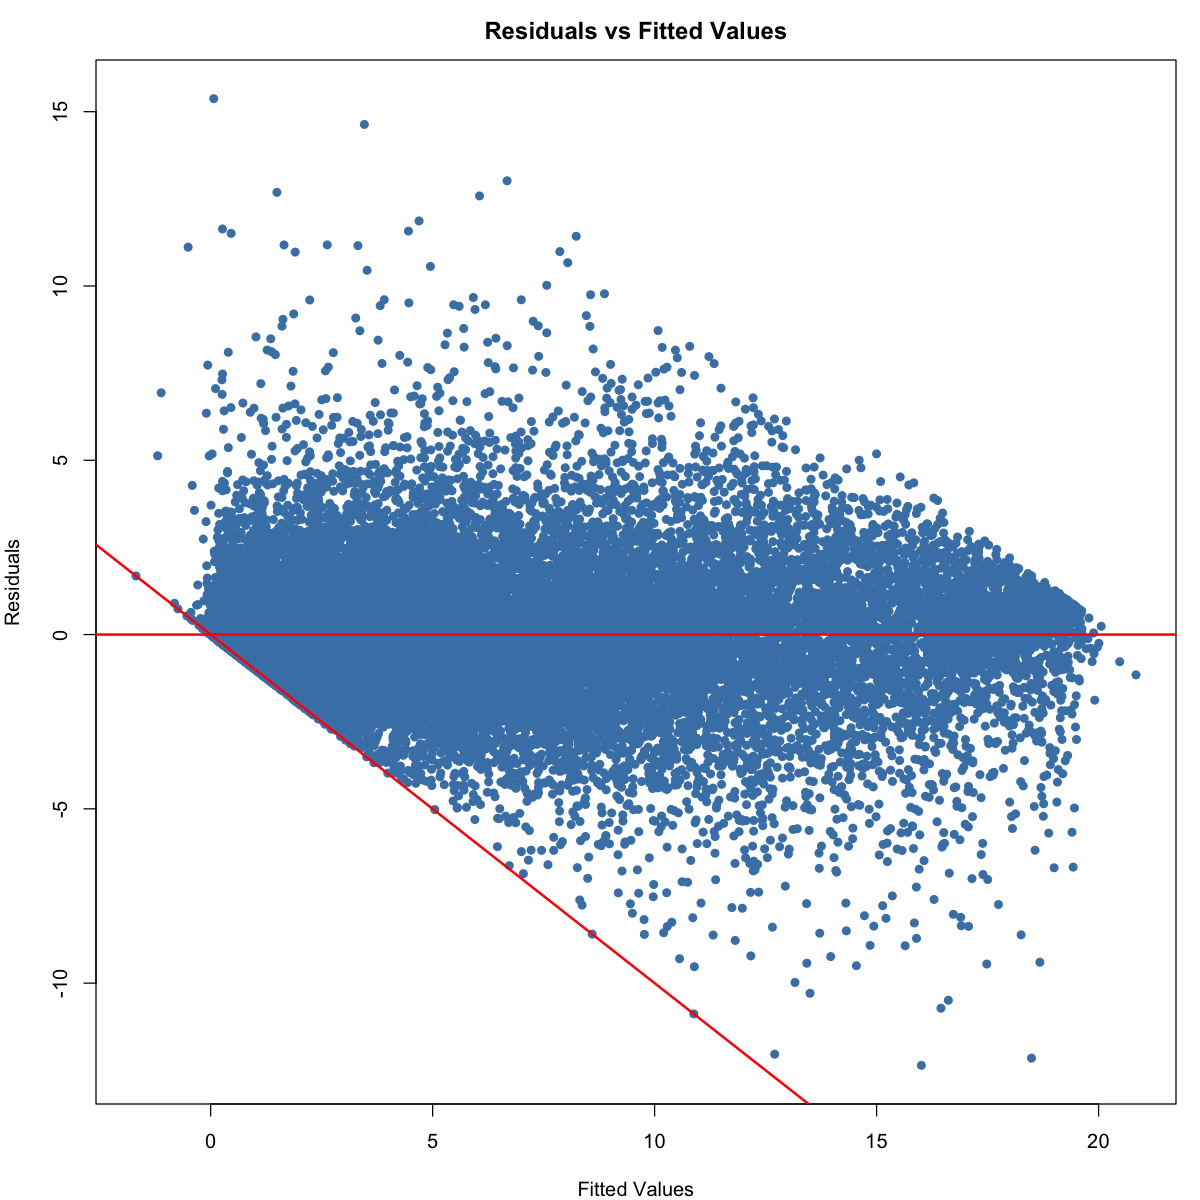

In [14]:
options(repr.plot.width=10, repr.plot.height=10)

m <- model.ar

## --- Compute residuals ---
res4 <- na.omit(residuals(m))

## --- 6 panel layout ---
par(mfrow = c(3, 2), mar = c(4,4,2.5,1))

## 1) Time Series of Residuals
plot(res4, type="l", col="steelblue",
     main="Time Series of Residuals", xlab="Time", ylab="Residuals")
abline(h=0, col="black")

## 2) Histogram
hist(res4, breaks = 40, freq = FALSE,
     col = "gray80", border = "white",
     main = "Residual Histogram with Normal Curve")

curve(dnorm(x, mean = mean(res4), sd = sd(res4)),
      col = "red", lwd = 3, add = TRUE)

## 3) Normal Q–Q Plot
qqnorm(res4, main="Normal Q-Q Plot")
qqline(res4, col="red", lwd=2)

## 4) Cumulative Periodogram
cpgram(res4, main="Cumulative Periodogram")

## 5) ACF plot
acf(res4, main="Auto-Correlation", lwd=2)

## 6) PACF plot
pacf(res4, main="Partial Auto-Correlation", lwd=2)

par(mfrow = c(1,1))


plot(fitted(m), m$residuals,
     xlab="Fitted Values", ylab="Residuals",
     main="Residuals vs Fitted Values",
     col="steelblue", pch=16)
abline(a = 0, b = -1, col = "red", lwd = 2)  # e = -ŷ lower bound "Because physics is bullying your regression."
abline(a = 0, b = 0, col = "red", lwd = 2)  # e = -ŷ lower bound "Because physics is bullying your regression."

The vertical spread is evidence of heteroscedasticity.

The residuals bending systematically, the clear asymmetry, and the lack of no random cloud around zero is evidence of non-linearity that the AR(4) model fails to capture. The AR model cannot capture the turbine power curve (nonlinear Ws → P mapping), cut-in / cut-out thresholds, directional dependence, seasonal roughness and saturation region.

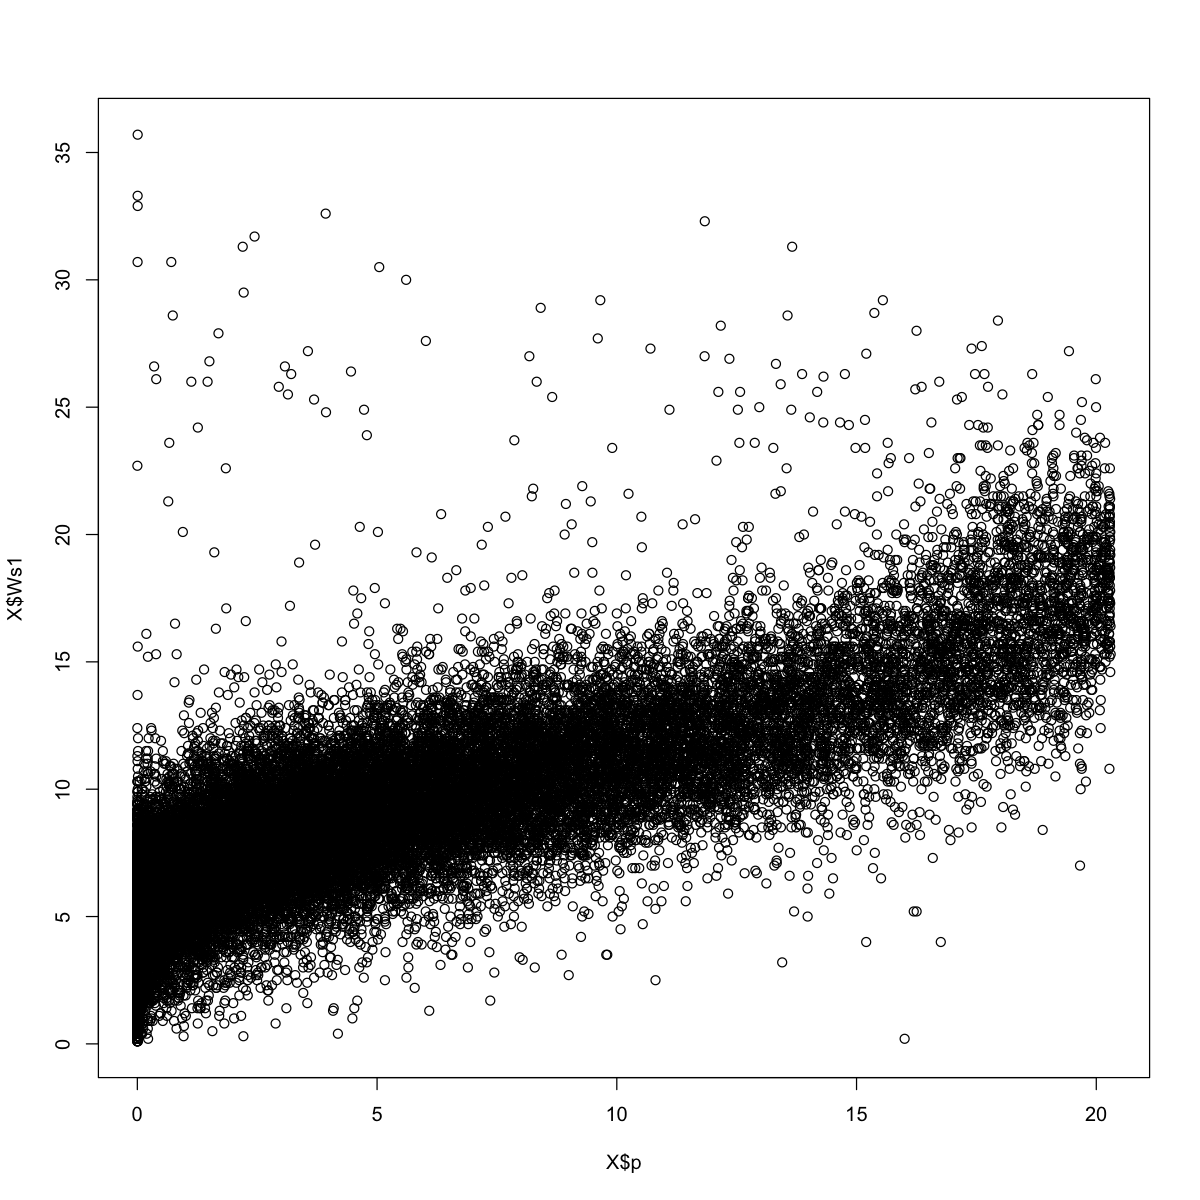

In [15]:
plot(X$p, X$Ws1)

In [16]:
df <- X
df$Wd1_rad <- df$Wd1 * pi/180 # convert degrees to radians since trigonometric functions in R use radians

mod_cont <- lm(
  p ~ 
    Ws1 + I(Ws1^2) +
    sin(Wd1_rad) + cos(Wd1_rad) +
    Ws1:sin(Wd1_rad) + Ws1:cos(Wd1_rad),
  data = df
)
summary(mod_cont)


Call:
lm(formula = p ~ Ws1 + I(Ws1^2) + sin(Wd1_rad) + cos(Wd1_rad) + 
    Ws1:sin(Wd1_rad) + Ws1:cos(Wd1_rad), data = df)

Residuals:
    Min      1Q  Median      3Q     Max 
-35.643  -1.866  -0.244   1.600  20.052 

Coefficients:
                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)      -3.7009902  0.0597104 -61.982  < 2e-16 ***
Ws1               0.9638727  0.0127895  75.364  < 2e-16 ***
I(Ws1^2)          0.0050702  0.0006378   7.950 1.92e-15 ***
sin(Wd1_rad)     -0.3867389  0.0530504  -7.290 3.16e-13 ***
cos(Wd1_rad)      0.5662118  0.0543524  10.417  < 2e-16 ***
Ws1:sin(Wd1_rad)  0.0016107  0.0059927   0.269    0.788    
Ws1:cos(Wd1_rad) -0.1278432  0.0061387 -20.826  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 3.043 on 36276 degrees of freedom
Multiple R-squared:  0.6935,	Adjusted R-squared:  0.6934 
F-statistic: 1.368e+04 on 6 and 36276 DF,  p-value: < 2.2e-16


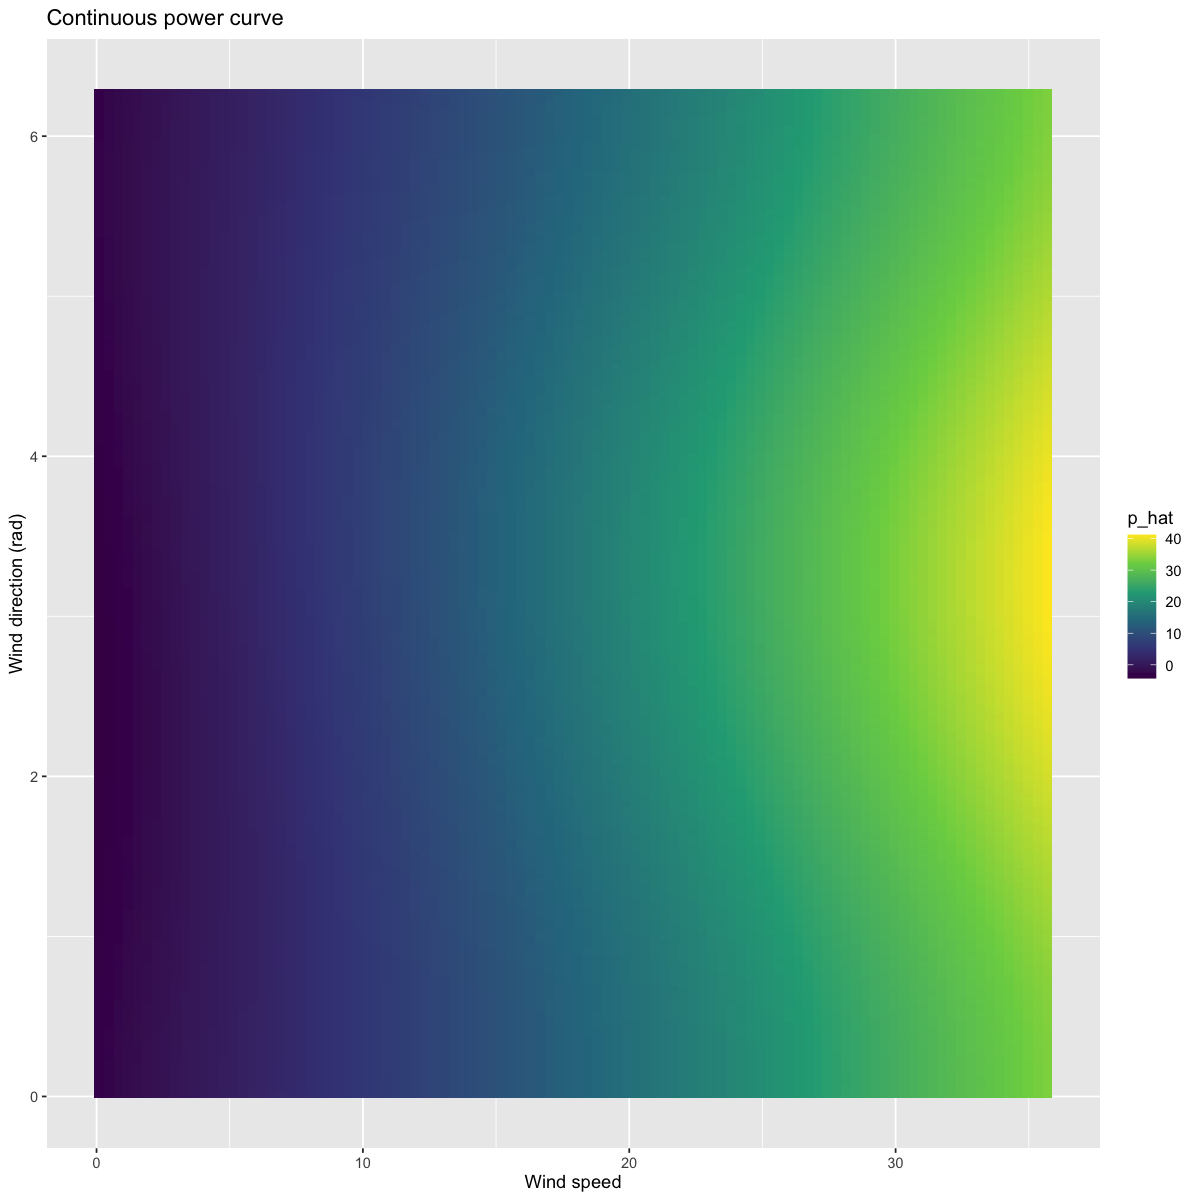

In [17]:
ws_grid <- seq(min(df$Ws1), max(df$Ws1), length.out = 100)
wd_grid <- seq(0, 2*pi, length.out = 360)

grid <- expand.grid(Ws1 = ws_grid, Wd1_rad = wd_grid)

grid$p_hat <- predict(mod_cont, newdata = grid)

library(ggplot2)

ggplot(grid, aes(Ws1, Wd1_rad, fill = p_hat)) +
  geom_tile() +
  scale_fill_viridis_c() +
  labs(title = "Continuous power curve",
       x = "Wind speed",
       y = "Wind direction (rad)")

In [18]:
df$Wd1_rad <- df$Wd1 * pi/180

mod <- lm(
  p ~ 
    Ws1 + I(Ws1^2) + I(Ws1^3) +
    sin(Wd1_rad) + cos(Wd1_rad) +
    sin(2*Wd1_rad) + cos(2*Wd1_rad) +
    Ws1:sin(Wd1_rad) + Ws1:cos(Wd1_rad),
  data = df
)

summary(mod)


Call:
lm(formula = p ~ Ws1 + I(Ws1^2) + I(Ws1^3) + sin(Wd1_rad) + cos(Wd1_rad) + 
    sin(2 * Wd1_rad) + cos(2 * Wd1_rad) + Ws1:sin(Wd1_rad) + 
    Ws1:cos(Wd1_rad), data = df)

Residuals:
     Min       1Q   Median       3Q      Max 
-19.4283  -1.3907  -0.2111   1.1155  30.1994 

Coefficients:
                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)       1.257e+00  7.650e-02  16.429  < 2e-16 ***
Ws1              -9.809e-01  2.444e-02 -40.134  < 2e-16 ***
I(Ws1^2)          2.056e-01  2.275e-03  90.359  < 2e-16 ***
I(Ws1^3)         -5.667e-03  6.193e-05 -91.503  < 2e-16 ***
sin(Wd1_rad)     -1.203e-01  4.737e-02  -2.540   0.0111 *  
cos(Wd1_rad)      1.787e-02  4.884e-02   0.366   0.7145    
sin(2 * Wd1_rad)  4.141e-01  2.084e-02  19.870  < 2e-16 ***
cos(2 * Wd1_rad)  5.411e-01  2.133e-02  25.370  < 2e-16 ***
Ws1:sin(Wd1_rad) -2.183e-02  5.368e-03  -4.066  4.8e-05 ***
Ws1:cos(Wd1_rad) -4.867e-02  5.580e-03  -8.722  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01


Recursive Least Squares is an adaptive version of ordinary least squares where the parameter vector is updated sequentially each time new data arrive. A forgetting factor assigns decreasing weight to older observations, allowing the model to track time-varying dynamics. The RLS recursion is mathematically equivalent to a Kalman filter applied to a linear state-space model with the parameter vector as the state. This makes RLS a natural choice for modelling and forecasting non-stationary systems such as wind-power production.


Forward-filling or using AR predictions to fill 6-day gaps in power data is not appropriate. Wind power is highly variable, and AR models only describe short-range temporal dependence; they cannot generate realistic multi-day forecasts. Filling these long gaps would introduce artificial autocorrelation and contaminate the model estimation. The correct approach in this project is simply to remove the missing p values and estimate the AR and regression models on the available data. This also aligns with the course methodology, where missing measurements are not imputed but ignored in the estimation.

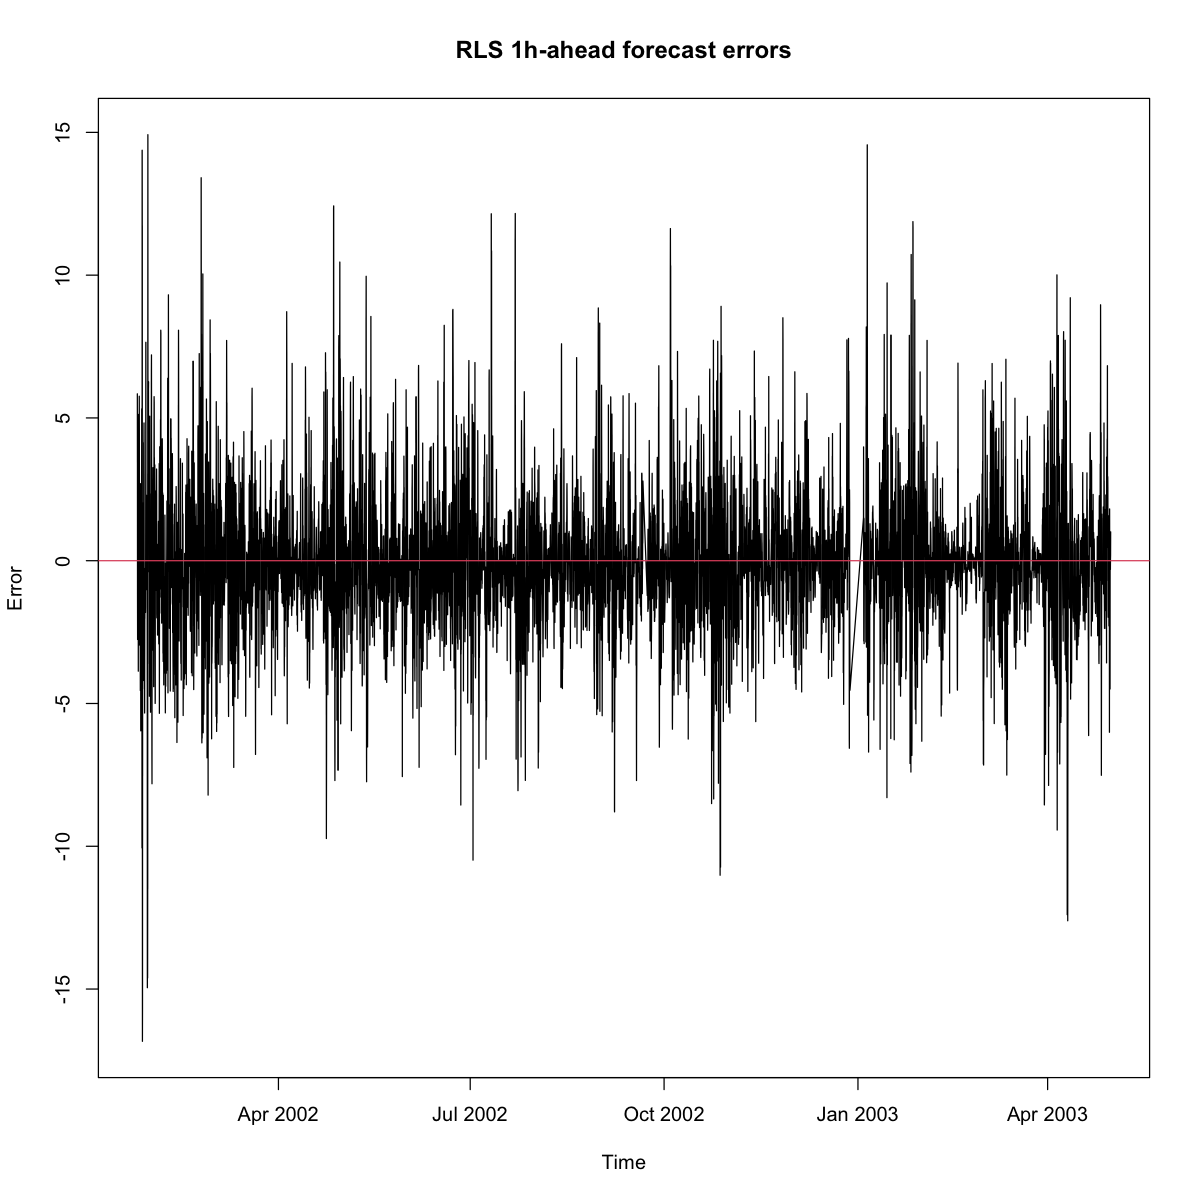

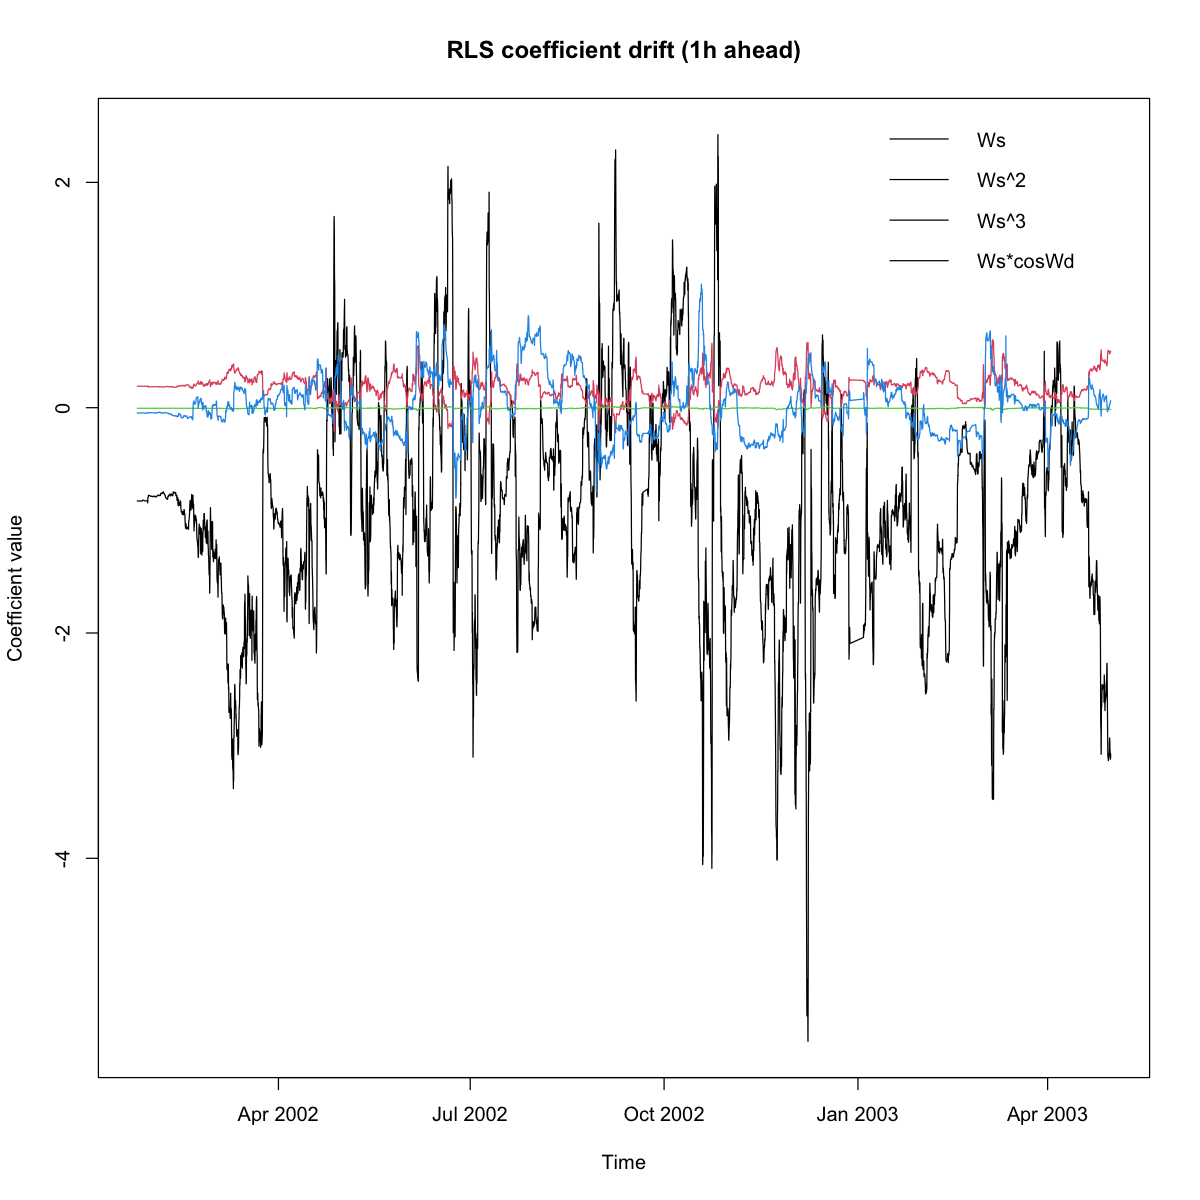

In [43]:
## --- 4) Plot error time series (validation only) ---
plot(res1$data$t[res1$idx_val], res1$y[res1$idx_val] - res1$rls_pred[res1$idx_val],
     type="l", xlab="Time", ylab="Error", main="RLS 1h-ahead forecast errors")
abline(h=0, col=2)

## --- 5) Plot a few coefficient paths (validation only) ---
# map coefficient indices to names
coef_names <- c("(Intercept)","Ws","Ws^2","Ws^3","sinWd","cosWd","sin2Wd","cos2Wd",
                "Ws*sinWd","Ws*cosWd","sinToy","cosToy")

# pick 3–5 to show
pick <- c("Ws","Ws^2","Ws^3","Ws*cosWd")
pick_idx <- match(pick, coef_names)

matplot(res1$data$t[res1$idx_val], res1$betas_rls[, pick_idx, drop=FALSE],
        type="l", lty=1, xlab="Time", ylab="Coefficient value",
        main="RLS coefficient drift (1h ahead)")
legend("topright", legend=pick, lty=1, bty="n")